# RATIO 2019 - Benchmarking Workshop

https://gluon-nlp.mxnet.io/install.html

```
pip install --upgrade 'mxnet>=1.3.0'
pip install gluonnlp
wget https://gluon-nlp.mxnet.io/_downloads/sentence_embedding.zip
unzip sentence_embedding.zip
ln -s sentence_embedding/bert bert
```

In [1]:
import datetime
import logging
import os
import random
import time
import warnings

import csv
import gluonnlp as nlp
import matplotlib.pyplot as plt
import mxnet as mx
import numpy as np
import pandas as pd
import seaborn as sns

from bert import *
from mxnet import gluon
from mxnet.gluon.data import SimpleDataset
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, f1_score)
from sklearn.model_selection import train_test_split
from sklearn import utils
from tqdm import tqdm

In [2]:
warnings.filterwarnings('ignore')

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s',
                    level=logging.INFO)

In [3]:
# set repeatable random state
np.random.seed(100)
random.seed(100)
mx.random.seed(10000)

In [4]:
# apply progress bars for pandas .apply() -> .progress_apply()
tqdm.pandas()

In [5]:
class Timer:
    def __init__(self, name=None):
        self.name = name

    def __enter__(self):
        self.time_start = time.time()

    def __exit__(self, *exc):
        time_end = time.time()
        time_delta = datetime.timedelta(seconds=(time_end - self.time_start))
        if self.name:
            print(("Time for [{}]: {}".format(self.name, time_delta)))
        else:
            print(("Time: {}".format(time_delta)))

# Task 1 - Same Side Classification

In [6]:
data_cross_path = 'data/same-side-classification/cross-topic/{}.csv'
data_within_path = 'data/same-side-classification/within-topic/{}.csv'

In [ ]:
%%bash
head -n 5 data/same-side-classification/cross-topic/training.csv

### Load within-topics and cross-topics data

In [7]:
# escapechar to detect quoting escapes, else it fails

# na_filter=False, because pandas automatic "nan" detection fails with the topic column, too
# cross_test_df['topic'].astype(str)[9270]

# within has "is_same_side" as string (boolean after latest update)
# cross has "is_same_side" as boolean (auto cast?)

with Timer("read cross"):
    # cross_traindev_df = pd.read_csv(data_cross_path.format('training'), index_col='id', escapechar='\\', na_filter=False)
    # cross_test_df = pd.read_csv(data_cross_path.format('test'), index_col='id', escapechar='\\', na_filter=False)
    cross_traindev_df = pd.read_csv(data_cross_path.format('training'),
                                    quotechar='"',
                                    quoting=csv.QUOTE_ALL,
                                    encoding='utf-8',
                                    escapechar='\\',
                                    doublequote=False,
                                    index_col='id')
    cross_test_df = pd.read_csv(data_cross_path.format('test'),
                                quotechar='"',
                                quoting=csv.QUOTE_ALL,
                                encoding='utf-8',
                                escapechar='\\',
                                doublequote=False,
                                index_col='id')

with Timer("read within"):
    # within_traindev_df = pd.read_csv(data_within_path.format('training'), index_col='id', escapechar='\\', na_filter=False)
    # within_test_df = pd.read_csv(data_within_path.format('test'), index_col='id', escapechar='\\', na_filter=False)
    within_traindev_df = pd.read_csv(data_within_path.format('training'),
                                     quotechar='"',
                                     quoting=csv.QUOTE_ALL,
                                     encoding='utf-8',
                                     escapechar='\\',
                                     doublequote=False,
                                     index_col='id')
    within_test_df = pd.read_csv(data_within_path.format('test'),
                                 quotechar='"',
                                 quoting=csv.QUOTE_ALL,
                                 encoding='utf-8',
                                 escapechar='\\',
                                 doublequote=False,
                                 index_col='id')

Time for [read cross]: 0:00:01.064160
Time for [read within]: 0:00:01.141815


#### [WIP][TODO] (temp) fix for invalid types

In [ ]:
np.unique(within_traindev_df[['is_same_side']], return_counts=True)

In [ ]:
# within_traindev_df = within_traindev_df[within_traindev_df[['is_same_side']]['is_same_side'] != 'gay marriage']

In [ ]:
# np.unique(within_traindev_df[['is_same_side']], return_counts=True)
# within_traindev_df.infer_objects().info()
# won't work: within_traindev_df['is_same_side'].astype(bool)

In [ ]:
# trim data for testing
within_traindev_df = within_traindev_df[:1000]
cross_traindev_df = cross_traindev_df[:1000]

In [8]:
# Adding a tag for the topics in focus: "gay marriage" and "abortion"
def add_tag(row):
    title = row['topic'].lower().strip()
    if "abortion" in title:
        row['tag'] = 'abortion'
    elif "gay marriage"  in title:
        row['tag'] = 'gay marriage'
    else:
        row['tag'] = 'NA'
    return row


with Timer("tag cross traindev"):
    cross_traindev_df = cross_traindev_df.apply(add_tag, axis=1)
# with Timer("tag cross test"):
#     cross_test_df = cross_test_df.apply(add_tag, axis=1)

with Timer("tag within traindev"):
    within_traindev_df = within_traindev_df.apply(add_tag, axis=1)
# with Timer("tag within test"):
#     within_test_df = within_test_df.apply(add_tag, axis=1)

Time for [tag cross traindev]: 0:00:35.821731
Time for [tag within traindev]: 0:00:37.371724


### Get an overview about each dataset

In [9]:
# requires nltk  wordtokenize
# from nltk.tokenize import sent_tokenize, word_tokenize
# model uses BERT Tokenizer ...

def get_overview(df, task='same-side', class_name='is_same_side'):
    # Total instance numbers
    total = len(df)
    print("Task: ", task)
    print('=' * 40, '\n')

    print('Total instances: ', total)
    print('\n')

    print('For each topic:')
    for tag, tag_df in df.groupby(['tag']):
        print(tag, ': ', len(tag_df), ' instances')
        if class_name in df.columns:
            for is_same_side, side_df in tag_df.groupby([class_name]):
                print('\t\t', is_same_side, ': ', len(side_df), ' instances')
    print('\n')

    if class_name in df.columns:
        print('For each class value:')
        for class_value, class_df in df.groupby([class_name]):
            print(class_value, ': ', len(class_df), ' instances')
        print('\n')

    print('Unique argument1:', len(df['argument1'].unique()))
    print('Unique argument2:', len(df['argument2'].unique()))
    arguments = df['argument1'].values
    arguments = np.concatenate([arguments, df['argument2'].values])

    print('Unique total arguments:', len(set(list(arguments))), '\n')

    print('-' * 40, '\n')

    arguments_length_lst = [
        len(word_tokenize(x)) for x in df['argument1'].values
    ]
    arguments_length_lst.extend(
        [len(word_tokenize(x)) for x in df['argument2'].values])
    print('Words:')
    print('\tshortest argument:', min(arguments_length_lst), ' words')
    print('\tlongest argument:', max(arguments_length_lst), ' words')
    print('\targument average length:', np.mean(arguments_length_lst),
          ' words')

    arguments_sent_length_lst = [
        len(sent_tokenize(x)) for x in df['argument1'].values
    ]
    arguments_sent_length_lst.extend(
        [len(sent_tokenize(x)) for x in df['argument2'].values])
    print('Sentences:')
    print('\tshortest argument:', min(arguments_sent_length_lst), ' sentences')
    print('\tlongest argument:', max(arguments_sent_length_lst), ' sentences')
    print('\targument average length:', np.mean(arguments_sent_length_lst),
          ' sentences')

In [ ]:
# with Timer("overview cross"):
#     get_overview(cross_traindev_df)

In [ ]:
# with Timer("overview within"):
#     get_overview(within_traindev_df)

## Train model - Baseline

### train dev set - 70% 30%

In [10]:
def get_train_test_sets(df, ratio=0.30, random_state=1):
    X = df[['argument1', 'argument2', 'argument1_id', 'argument2_id', 'topic']]
    y = df[['is_same_side']]

    X_train, X_test, y_train, y_test = train_test_split(X,
                                                        y,
                                                        test_size=ratio,
                                                        random_state=random_state,
                                                        shuffle=True)
    return X_train, X_test, y_train, y_test

### BERT

- https://gluon-nlp.mxnet.io/examples/sentence_embedding/bert.html

In [11]:
class MyBERTDataset(SimpleDataset):
    def __init__(self, X, y=None):
        self._X = X
        self._y = y
        super(MyBERTDataset, self).__init__(self._convert())
    
    def _convert(self):
        allsamples = list()

        if self._y is not None:
            df = self._X.merge(self._y, left_index=True, right_index=True)
            for _, row in df.iterrows():
                allsamples.append([row['argument1'], row['argument2'], 1 if str(row['is_same_side']) == "True" else 0])
        else:
            for _, row in self._X.iterrows():
                allsamples.append([row['argument1'], row['argument2'], None])
        
        return allsamples

    # for lazy retrieval?
    #
    # def __getitem__(self, idx):
    #     row_X = self._X.iloc[idx]
    #     row_y = self._y.iloc[idx]
    #     return [row_X['argument1'], row_X['argument2'], "1" if row_y['is_same_side'] else "0"]
    #
    # def __len__(self):
    #     return len(self._X)

In [ ]:
# df = X_dev.merge(y_dev, left_index=True, right_index=True)
# allsamples = list()
# for _, row in df.iterrows():
#     allsamples.append("1" if row['is_same_side'] == "True" else "0")
# np.unique(allsamples)

In [12]:
def setup_bert():
    # change `ctx` to `mx.cpu()` if no GPU is available.
    ctx = mx.gpu(0)
    # ctx =  mx.gpu() if mx.context.num_gpus() else mx.cpu()
    # ctx = mx.cpu()

    bert_base, vocabulary = nlp.model.get_model(
        'bert_12_768_12',
        dataset_name='book_corpus_wiki_en_uncased',
        pretrained=True,
        ctx=ctx,
        use_pooler=True,
        use_decoder=False,
        use_classifier=False)
    print(bert_base)

    model = bert.BERTClassifier(bert_base, num_classes=1, dropout=0.1)
    # only need to initialize the classifier layer.
    model.classifier.initialize(init=mx.init.Normal(0.02), ctx=ctx)
    model.hybridize(static_alloc=True)

    # sigmoid binary cross entropy loss for classification
    loss_function = gluon.loss.SigmoidBinaryCrossEntropyLoss(from_sigmoid=False)
    loss_function.hybridize(static_alloc=True)

    metric = mx.metric.Accuracy()

    # use the vocabulary from pre-trained model for tokenization
    bert_tokenizer = nlp.data.BERTTokenizer(vocabulary, lower=True)
    # maximum sequence length
    max_len = 128
    # the labels for the two classes
    all_labels = [0, 1]
    # whether to transform the data as sentence pairs.
    # for single sentence classification, set pair=False
    pair = True
    transform = dataset.BERTDatasetTransform(bert_tokenizer,
                                             max_len,
                                             labels=all_labels,
                                             label_dtype='int32',
                                             pad=True,
                                             pair=pair)

    return model, vocabulary, ctx, transform, loss_function, metric, all_labels

In [13]:
def transform_dataset(X, y, transform):
    data_train_raw = MyBERTDataset(X, y)
    data_train = data_train_raw.transform(transform)
    return data_train_raw, data_train


def predict_out_to_ys(all_predictions, all_labels):
    y_true, y_pred = list(), list()
    
    for _, y_true_many, y_pred_many in all_predictions:
        # convert floats to ints ("0" and "1"?)
        # y_true_many = y_true_many.astype('int32')
        # y_pred_many = y_pred_many.sigmoid().round().astype('int32')

        # convert into numpy
        y_true_many = y_true_many.T[0].asnumpy()
        # https://mxnet.incubator.apache.org/api/python/gluon/loss.html#mxnet.gluon.loss.SoftmaxCrossEntropyLoss
        # pred: the prediction tensor, where the batch_axis dimension ranges over batch size and axis dimension ranges over the number of classes.
        # y_pred_many = np.argmax(y_pred_many, axis=1).asnumpy()
        # y_pred_many = np.sigmoid(y_pred_many, axis=1).asnumpy()
        y_pred_many = y_pred_many.asnumpy()

        y_true.extend(list(y_true_many))
        y_pred.extend(list(y_pred_many))
        # TODO: convert label_id to label?
        # y_pred.extend(all_labels[c] for c in list(y_pred_many))
        
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    return y_true, y_pred

In [24]:
def train(model, data_train, ctx, metric, loss_function, batch_size=32, lr=5e-6, num_epochs=3, checkpoint_dir="data", use_checkpoints=True):
    with Timer("setup training"):
        train_sampler = nlp.data.FixedBucketSampler(
            lengths=[int(item[1]) for item in tqdm(data_train)],
            batch_size=batch_size,
            shuffle=True)
        bert_dataloader = mx.gluon.data.DataLoader(data_train,
                                                   batch_sampler=train_sampler)

        trainer = gluon.Trainer(model.collect_params(), 'adam', {
            'learning_rate': lr,
            'epsilon': 1e-9
        })

        # collect all differentiable parameters
        # grad_req == 'null' indicates no gradients are calculated (e.g. constant parameters)
        # the gradients for these params are clipped later
        params = [p for p in model.collect_params().values() if p.grad_req != 'null']

    log_interval = 10
    with Timer("training"):
        stats = list()
        for epoch_id in range(num_epochs):
            if use_checkpoints:
                epoch_checkpoint_savefile = "bert.model.checkpoint{}.params".format(epoch_id)
                if checkpoint_dir is not None:
                    epoch_checkpoint_savefile = os.path.join(checkpoint_dir, epoch_checkpoint_savefile)
                if os.path.exists(epoch_checkpoint_savefile):
                    model.load_parameters(epoch_checkpoint_savefile, ctx=ctx)
                    print("loaded checkpoint for epoch {}".format(epoch_id))
                    continue

            with Timer("epoch {}".format(epoch_id)):
                metric.reset()
                step_loss = 0
                t_p = time.time()  # time keeping
                for batch_id, (token_ids, valid_length, segment_ids,
                               label) in enumerate(bert_dataloader):
                    with mx.autograd.record():
                        # load data to GPU
                        token_ids = token_ids.as_in_context(ctx)
                        valid_length = valid_length.as_in_context(ctx)
                        segment_ids = segment_ids.as_in_context(ctx)
                        label = label.as_in_context(ctx)

                        # forward computation
                        out = model(token_ids, segment_ids,
                                    valid_length.astype('float32'))
                        # TODO: make "label" a 2 component list? (0, 1) for "0" and (1, 0) for "1" ?
                        label = label.astype('float32')
                        ls = loss_function(out, label).mean()

                    # backward computation
                    ls.backward()

                    # gradient clipping
                    trainer.allreduce_grads()
                    nlp.utils.clip_grad_global_norm(params, 1)
                    trainer.update(1)

                    step_loss += ls.asscalar()
                    # TODO: what is the value range? --> needs sigmoid?
                    out = out.sigmoid().round().astype('int32')
                    label = label.astype('int32')
                    metric.update([label], [out])
                    stats.append((metric.get()[1], ls.asscalar()))
                    if (batch_id + 1) % (log_interval) == 0:
                        print(
                            '[Epoch {} Batch {}/{}] loss={:.4f}, lr={:.7f}, acc={:.3f} - time {}'
                            .format(epoch_id, batch_id + 1, len(bert_dataloader),
                                    step_loss / log_interval, trainer.learning_rate,
                                    metric.get()[1],
                                    datetime.timedelta(seconds=(time.time() - t_p))))
                        t_p = time.time()
                        step_loss = 0

            if use_checkpoints:
                model.save_parameters(epoch_checkpoint_savefile)
            
    return stats

In [25]:
def predict(model, data_predict, ctx, metric, loss_function, batch_size=32):
    bert_dataloader = mx.gluon.data.DataLoader(data_predict, batch_size=batch_size)
    
    all_predictions = list()

    with Timer("prediction"):
        metric.reset()
        cum_loss = 0
        for batch_id, (token_ids, valid_length, segment_ids,
                       label) in enumerate(tqdm(bert_dataloader)):
            # load data to GPU
            token_ids = token_ids.as_in_context(ctx)
            valid_length = valid_length.as_in_context(ctx)
            segment_ids = segment_ids.as_in_context(ctx)
            label = label.as_in_context(ctx)

            # forward computation
            out = model(token_ids, segment_ids,
                        valid_length.astype('float32'))
            label = label.astype('float32')
            ls = loss_function(out, label).mean()
            cum_loss += ls.asscalar()  # .sum() ?

            # somehow convert it into a binary value ...
            out = out.sigmoid().round().astype('int32')
            label = label.astype('int32')
            metric.update([label], [out])
            all_predictions.append((batch_id, label, out))
            
    return all_predictions, cum_loss

In [ ]:
# def sigmoid(x, derivative=False):
#     return x * (1 - x) if derivative else 1 / (1 + np.exp(-x))
# sigmoid(-1), sigmoid(0), sigmoid(1)

In [16]:
def print_infos(vocabulary, data_train_raw, data_train):
    sample_id = 0

    # sentence a
    print(data_train_raw[sample_id][0])
    # sentence b
    print(data_train_raw[sample_id][1])
    # 1 means equivalent, 0 means not equivalent
    print(data_train_raw[sample_id][2])

    print('vocabulary used for tokenization = \n%s' % vocabulary)
    print('[PAD] token id = %s' % (vocabulary['[PAD]']))
    print('[CLS] token id = %s' % (vocabulary['[CLS]']))
    print('[SEP] token id = %s' % (vocabulary['[SEP]']))

    print('token ids = \n%s' % data_train[sample_id][0])
    print('valid length = \n%s' % data_train[sample_id][1])
    print('segment ids = \n%s' % data_train[sample_id][2])
    print('label = \n%s' % data_train[sample_id][3])


def plot_train_stats(stats):
    if not stats:
        print("no stats to plot")
        return

    x = np.arange(len(stats))  # arange/linspace

    acc_dots, loss_dots = zip(*stats)

    plt.subplot(2, 1, 1)
    plt.plot(x, acc_dots)  # Linie: '-', 'o-', '.-'
    plt.title('Training BERTClassifier')
    plt.ylabel('Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(x, loss_dots)
    plt.xlabel('Batches')
    plt.ylabel('Loss')

    plt.show()

### Evaluate

In [17]:
def heatconmat(y_test, y_pred):
    sns.set_context('talk')
    plt.figure(figsize=(9, 6))
    sns.heatmap(confusion_matrix(y_test, y_pred),
                annot=True,
                fmt='d',
                cbar=False,
                cmap='gist_earth_r',
                yticklabels=sorted(np.unique(y_test)))
    plt.show()


def report_training_results(y_test, y_pred, name=None, heatmap=True):
    print('Confusion Matrix:')
    print(confusion_matrix(y_test, y_pred))
    if heatmap:
        heatconmat(y_test, y_pred)
    print()
    print('Accuracy: ', round(accuracy_score(y_test, y_pred), 2), '\n')  #

    print('Report{}:'.format("" if not name else " for [{}]".format(name)))
    print(classification_report(y_test, y_pred))

    f1_dic = {}
    f1_dic['macro'] = round(
        f1_score(y_pred=y_pred, y_true=y_test, average='macro'), 2)
    f1_dic['micro'] = round(
        f1_score(y_pred=y_pred, y_true=y_test, average='micro'), 2)
    return f1_dic

### Within topic - Training and evaluating model 

In [18]:
# 1. Getting train and dev data
with Timer("1 - test/train split"):
    X_train, X_dev, y_train, y_dev = get_train_test_sets(within_traindev_df)

Time for [1 - test/train split]: 0:00:00.022546


In [19]:
# 2. setup
with Timer("2 - setup BERT model"):
    model, vocabulary, ctx, transform, loss_function, metric, all_labels = setup_bert()

BERTModel(
  (encoder): BERTEncoder(
    (dropout_layer): Dropout(p = 0.1, axes=())
    (layer_norm): BERTLayerNorm(eps=1e-12, axis=-1, center=True, scale=True, in_channels=768)
    (transformer_cells): HybridSequential(
      (0): BERTEncoderCell(
        (dropout_layer): Dropout(p = 0.1, axes=())
        (attention_cell): MultiHeadAttentionCell(
          (_base_cell): DotProductAttentionCell(
            (_dropout_layer): Dropout(p = 0.1, axes=())
          )
          (proj_query): Dense(768 -> 768, linear)
          (proj_key): Dense(768 -> 768, linear)
          (proj_value): Dense(768 -> 768, linear)
        )
        (proj): Dense(768 -> 768, linear)
        (ffn): BERTPositionwiseFFN(
          (ffn_1): Dense(768 -> 3072, linear)
          (activation): GELU()
          (ffn_2): Dense(3072 -> 768, linear)
          (dropout_layer): Dropout(p = 0.1, axes=())
          (layer_norm): BERTLayerNorm(eps=1e-12, axis=-1, center=True, scale=True, in_channels=768)
        )
        (la

In [20]:
with Timer("3 - prepare training data"):
    data_train_raw, data_train = transform_dataset(X_train, y_train, transform)
    print_infos(vocabulary, data_train_raw, data_train)

wanted fetuses are beloved "babies"; unwanted ones are "tissue" (inconsistent)
abortions are emotionally and psychologically unsafe.
1
vocabulary used for tokenization = 
Vocab(size=30522, unk="[UNK]", reserved="['[PAD]', '[CLS]', '[SEP]', '[MASK]']")
[PAD] token id = 1
[CLS] token id = 2
[SEP] token id = 3
token ids = 
[    2  2359 10768  5809  2229  2024 11419  1000 10834  1000  1025 18162
  3924  2024  1000  8153  1000  1006 20316  1007     3 11324  2015  2024
 14868  1998  8317  2135 25135  1012     3     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1   

In [ ]:
with Timer("4 - train model"):
    # train(model, data_train, ctx, metric, loss_function, batch_size=32, lr=5e-6, num_epochs=3)
    stats = train(model, data_train, ctx, metric, loss_function, batch_size=32, lr=5e-6, num_epochs=2)
    # model.save_parameters("data/same-side-classification/within-topic/bert.model.params")
    model.save_parameters("data/bert.model.params")

    plot_train_stats(stats)

In [21]:
with Timer("5 - prepare eval data"):
    data_dev_raw, data_dev = transform_dataset(X_dev, y_dev, transform)
    print_infos(vocabulary, data_dev_raw, data_dev)

abortion opens the door to the sexual exploitation of women the existence of abortion gives men a little more of a safeguard against unintentionally impregnating a woman. as a result, men will be more aggressive in their sexual exploitation of women.
the fact that a child is likely to have a short life does not justify further shortening it:
0
vocabulary used for tokenization = 
Vocab(size=30522, unk="[UNK]", reserved="['[PAD]', '[CLS]', '[SEP]', '[MASK]']")
[PAD] token id = 1
[CLS] token id = 2
[SEP] token id = 3
token ids = 
[    2 11324  7480  1996  2341  2000  1996  4424 14427  1997  2308  1996
  4598  1997 11324  3957  2273  1037  2210  2062  1997  1037 28805  2114
  4895 18447  4765 19301  2135 17727  2890 16989  3436  1037  2450  1012
  2004  1037  2765  1010  2273  2097  2022  2062  9376  1999  2037  4424
 14427  1997  2308  1012     3  1996  2755  2008  1037  2775  2003  3497
  2000  2031  1037  2460  2166  2515  2025 16114  2582  2460  7406  2009
  1024     3     1     1     

In [22]:
with Timer("6 - evaluate"):
    # model.load_parameters("data/same-side-classification/within-topic/bert.model.params", ctx=ctx)
    # model.load_parameters("data/bert.model.params", ctx=ctx)
    all_predictions, cum_loss = predict(model, data_dev, ctx, metric, loss_function)
    print("Accuracy:", metric.get()[1])

    y_true, y_pred = predict_out_to_ys(all_predictions, all_labels)
    report_training_results(y_true, y_pred, name="BERTClassifier", heatmap=False)

100%|██████████| 600/600 [03:26<00:00,  2.90it/s]


Time for [prediction]: 0:03:26.738696
Accuracy: 0.46074800479891503
Confusion Matrix:
[[  157  8676]
 [  113 10225]]

Accuracy:  0.54 

Report for [BERTClassifier]:
              precision    recall  f1-score   support

           0       0.58      0.02      0.03      8833
           1       0.54      0.99      0.70     10338

    accuracy                           0.54     19171
   macro avg       0.56      0.50      0.37     19171
weighted avg       0.56      0.54      0.39     19171

Time for [6 - evaluate]: 0:03:26.896612


### Train and evaluate each epoch

100%|██████████| 44732/44732 [03:45<00:00, 198.55it/s]


Time for [setup training]: 0:03:45.319735
[Epoch 0 Batch 10/1401] loss=0.6961, lr=0.0000050, acc=0.431 - time 0:00:09.920489
[Epoch 0 Batch 20/1401] loss=0.6924, lr=0.0000050, acc=0.436 - time 0:00:08.680592
[Epoch 0 Batch 30/1401] loss=0.7056, lr=0.0000050, acc=0.448 - time 0:00:08.004687
[Epoch 0 Batch 40/1401] loss=0.6946, lr=0.0000050, acc=0.452 - time 0:00:08.980664
[Epoch 0 Batch 50/1401] loss=0.7079, lr=0.0000050, acc=0.471 - time 0:00:09.195688
[Epoch 0 Batch 60/1401] loss=0.6954, lr=0.0000050, acc=0.475 - time 0:00:07.964588
[Epoch 0 Batch 70/1401] loss=0.6767, lr=0.0000050, acc=0.472 - time 0:00:08.705266
[Epoch 0 Batch 80/1401] loss=0.6863, lr=0.0000050, acc=0.466 - time 0:00:09.382693
[Epoch 0 Batch 90/1401] loss=0.6809, lr=0.0000050, acc=0.465 - time 0:00:07.395756
[Epoch 0 Batch 100/1401] loss=0.6986, lr=0.0000050, acc=0.465 - time 0:00:09.457565
[Epoch 0 Batch 110/1401] loss=0.6863, lr=0.0000050, acc=0.468 - time 0:00:09.925417
[Epoch 0 Batch 120/1401] loss=0.6782, lr=0.

[Epoch 0 Batch 990/1401] loss=0.2926, lr=0.0000050, acc=0.407 - time 0:00:08.088883
[Epoch 0 Batch 1000/1401] loss=0.3217, lr=0.0000050, acc=0.406 - time 0:00:08.129474
[Epoch 0 Batch 1010/1401] loss=0.2905, lr=0.0000050, acc=0.404 - time 0:00:08.431885
[Epoch 0 Batch 1020/1401] loss=0.3038, lr=0.0000050, acc=0.403 - time 0:00:08.558315
[Epoch 0 Batch 1030/1401] loss=0.4075, lr=0.0000050, acc=0.401 - time 0:00:08.855155
[Epoch 0 Batch 1040/1401] loss=0.4302, lr=0.0000050, acc=0.399 - time 0:00:09.697773
[Epoch 0 Batch 1050/1401] loss=0.2672, lr=0.0000050, acc=0.398 - time 0:00:08.453356
[Epoch 0 Batch 1060/1401] loss=0.3099, lr=0.0000050, acc=0.396 - time 0:00:08.680097
[Epoch 0 Batch 1070/1401] loss=0.3031, lr=0.0000050, acc=0.394 - time 0:00:09.012539
[Epoch 0 Batch 1080/1401] loss=0.2982, lr=0.0000050, acc=0.392 - time 0:00:08.895362
[Epoch 0 Batch 1090/1401] loss=0.3654, lr=0.0000050, acc=0.391 - time 0:00:08.804142
[Epoch 0 Batch 1100/1401] loss=0.3949, lr=0.0000050, acc=0.389 - t

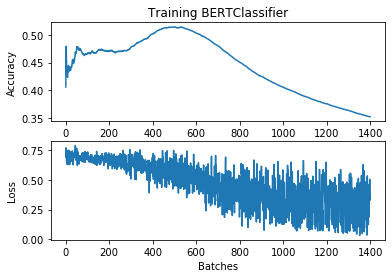

  0%|          | 0/600 [00:00<?, ?it/s]

Time for [4 - train model - 0]: 0:24:45.699748


100%|██████████| 600/600 [04:04<00:00,  2.46it/s]


Time for [prediction]: 0:04:04.280435
Accuracy in epoch 0: 0.19701632674351885
Confusion Matrix:
[[7988  845]
 [2345 7993]]

Accuracy:  0.83 

Report for [BERTClassifier]:
              precision    recall  f1-score   support

           0       0.77      0.90      0.83      8833
           1       0.90      0.77      0.83     10338

    accuracy                           0.83     19171
   macro avg       0.84      0.84      0.83     19171
weighted avg       0.84      0.83      0.83     19171

Time for [6 - evaluate - 0]: 0:04:04.523398


100%|██████████| 44732/44732 [04:59<00:00, 149.57it/s]


Time for [setup training]: 0:04:59.103166
loaded checkpoint for epoch 0
[Epoch 1 Batch 10/1401] loss=0.3285, lr=0.0000050, acc=0.250 - time 0:00:10.745124
[Epoch 1 Batch 20/1401] loss=0.2673, lr=0.0000050, acc=0.233 - time 0:00:09.112513
[Epoch 1 Batch 30/1401] loss=0.2888, lr=0.0000050, acc=0.226 - time 0:00:09.778834
[Epoch 1 Batch 40/1401] loss=0.3274, lr=0.0000050, acc=0.207 - time 0:00:11.053503
[Epoch 1 Batch 50/1401] loss=0.2353, lr=0.0000050, acc=0.201 - time 0:00:09.047440
[Epoch 1 Batch 60/1401] loss=0.3437, lr=0.0000050, acc=0.205 - time 0:00:10.055071
[Epoch 1 Batch 70/1401] loss=0.3335, lr=0.0000050, acc=0.202 - time 0:00:11.160190
[Epoch 1 Batch 80/1401] loss=0.3127, lr=0.0000050, acc=0.212 - time 0:00:09.679897
[Epoch 1 Batch 90/1401] loss=0.3487, lr=0.0000050, acc=0.215 - time 0:00:11.083546
[Epoch 1 Batch 100/1401] loss=0.2882, lr=0.0000050, acc=0.211 - time 0:00:10.695992
[Epoch 1 Batch 110/1401] loss=0.2887, lr=0.0000050, acc=0.209 - time 0:00:08.072761
[Epoch 1 Batc

[Epoch 1 Batch 980/1401] loss=0.1835, lr=0.0000050, acc=0.182 - time 0:00:09.166056
[Epoch 1 Batch 990/1401] loss=0.2422, lr=0.0000050, acc=0.182 - time 0:00:09.917886
[Epoch 1 Batch 1000/1401] loss=0.1963, lr=0.0000050, acc=0.182 - time 0:00:08.092595
[Epoch 1 Batch 1010/1401] loss=0.2855, lr=0.0000050, acc=0.182 - time 0:00:11.438907
[Epoch 1 Batch 1020/1401] loss=0.3186, lr=0.0000050, acc=0.182 - time 0:00:10.357720
[Epoch 1 Batch 1030/1401] loss=0.3108, lr=0.0000050, acc=0.183 - time 0:00:09.921207
[Epoch 1 Batch 1040/1401] loss=0.3255, lr=0.0000050, acc=0.183 - time 0:00:12.349589
[Epoch 1 Batch 1050/1401] loss=0.2212, lr=0.0000050, acc=0.183 - time 0:00:09.279396
[Epoch 1 Batch 1060/1401] loss=0.3276, lr=0.0000050, acc=0.183 - time 0:00:09.290304
[Epoch 1 Batch 1070/1401] loss=0.2357, lr=0.0000050, acc=0.183 - time 0:00:09.418319
[Epoch 1 Batch 1080/1401] loss=0.2586, lr=0.0000050, acc=0.183 - time 0:00:08.628220
[Epoch 1 Batch 1090/1401] loss=0.2491, lr=0.0000050, acc=0.183 - ti

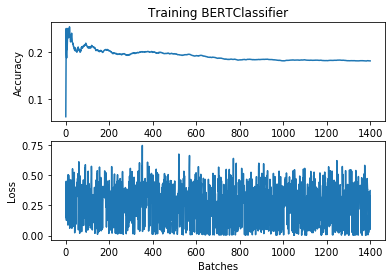

  0%|          | 0/600 [00:00<?, ?it/s]

Time for [4 - train model - 1]: 0:28:13.717215


100%|██████████| 600/600 [04:10<00:00,  2.39it/s]


Time for [prediction]: 0:04:10.848778
Accuracy in epoch 1: 0.1519482551770904
Confusion Matrix:
[[8182  651]
 [2370 7968]]

Accuracy:  0.84 

Report for [BERTClassifier]:
              precision    recall  f1-score   support

           0       0.78      0.93      0.84      8833
           1       0.92      0.77      0.84     10338

    accuracy                           0.84     19171
   macro avg       0.85      0.85      0.84     19171
weighted avg       0.86      0.84      0.84     19171

Time for [6 - evaluate - 1]: 0:04:11.020348


100%|██████████| 44732/44732 [05:01<00:00, 148.51it/s]


Time for [setup training]: 0:05:01.231010
loaded checkpoint for epoch 0
loaded checkpoint for epoch 1
[Epoch 2 Batch 10/1401] loss=0.2972, lr=0.0000050, acc=0.178 - time 0:00:09.485846
[Epoch 2 Batch 20/1401] loss=0.2645, lr=0.0000050, acc=0.173 - time 0:00:09.456458
[Epoch 2 Batch 30/1401] loss=0.2152, lr=0.0000050, acc=0.143 - time 0:00:07.889599
[Epoch 2 Batch 40/1401] loss=0.1942, lr=0.0000050, acc=0.142 - time 0:00:09.810235
[Epoch 2 Batch 50/1401] loss=0.1889, lr=0.0000050, acc=0.137 - time 0:00:08.419495
[Epoch 2 Batch 60/1401] loss=0.3338, lr=0.0000050, acc=0.145 - time 0:00:09.014098
[Epoch 2 Batch 70/1401] loss=0.2845, lr=0.0000050, acc=0.156 - time 0:00:09.980943
[Epoch 2 Batch 80/1401] loss=0.2621, lr=0.0000050, acc=0.156 - time 0:00:09.478998
[Epoch 2 Batch 90/1401] loss=0.2602, lr=0.0000050, acc=0.155 - time 0:00:08.059942
[Epoch 2 Batch 100/1401] loss=0.2198, lr=0.0000050, acc=0.154 - time 0:00:09.254570
[Epoch 2 Batch 110/1401] loss=0.2194, lr=0.0000050, acc=0.156 - tim

[Epoch 2 Batch 980/1401] loss=0.2741, lr=0.0000050, acc=0.154 - time 0:00:09.119232
[Epoch 2 Batch 990/1401] loss=0.2304, lr=0.0000050, acc=0.154 - time 0:00:09.190546
[Epoch 2 Batch 1000/1401] loss=0.2384, lr=0.0000050, acc=0.153 - time 0:00:09.378551
[Epoch 2 Batch 1010/1401] loss=0.1903, lr=0.0000050, acc=0.153 - time 0:00:08.568183
[Epoch 2 Batch 1020/1401] loss=0.2071, lr=0.0000050, acc=0.153 - time 0:00:08.658794
[Epoch 2 Batch 1030/1401] loss=0.1951, lr=0.0000050, acc=0.153 - time 0:00:09.326578
[Epoch 2 Batch 1040/1401] loss=0.2513, lr=0.0000050, acc=0.152 - time 0:00:09.081558
[Epoch 2 Batch 1050/1401] loss=0.2101, lr=0.0000050, acc=0.152 - time 0:00:08.997560
[Epoch 2 Batch 1060/1401] loss=0.2722, lr=0.0000050, acc=0.152 - time 0:00:09.943018
[Epoch 2 Batch 1070/1401] loss=0.1521, lr=0.0000050, acc=0.152 - time 0:00:08.779630
[Epoch 2 Batch 1080/1401] loss=0.2990, lr=0.0000050, acc=0.152 - time 0:00:08.490947
[Epoch 2 Batch 1090/1401] loss=0.2483, lr=0.0000050, acc=0.152 - ti

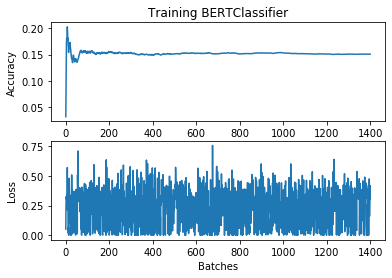

  0%|          | 0/600 [00:00<?, ?it/s]

Time for [4 - train model - 2]: 0:26:14.819707


100%|██████████| 600/600 [03:30<00:00,  2.85it/s]


Time for [prediction]: 0:03:30.549088
Accuracy in epoch 2: 0.16185905795211517
Confusion Matrix:
[[7118 1715]
 [1303 9035]]

Accuracy:  0.84 

Report for [BERTClassifier]:
              precision    recall  f1-score   support

           0       0.85      0.81      0.83      8833
           1       0.84      0.87      0.86     10338

    accuracy                           0.84     19171
   macro avg       0.84      0.84      0.84     19171
weighted avg       0.84      0.84      0.84     19171

Time for [6 - evaluate - 2]: 0:03:30.683898


100%|██████████| 44732/44732 [03:45<00:00, 197.98it/s]


Time for [setup training]: 0:03:45.974465
loaded checkpoint for epoch 0
loaded checkpoint for epoch 1
loaded checkpoint for epoch 2
[Epoch 3 Batch 10/1401] loss=0.2470, lr=0.0000050, acc=0.184 - time 0:00:09.002416
[Epoch 3 Batch 20/1401] loss=0.1955, lr=0.0000050, acc=0.177 - time 0:00:08.643405
[Epoch 3 Batch 30/1401] loss=0.1866, lr=0.0000050, acc=0.164 - time 0:00:08.529515
Time for [epoch 3]: 0:00:33.850914
Time for [training]: 0:00:34.430717
Time for [4 - train model - 3]: 0:04:20.405564


KeyboardInterrupt: 

In [23]:
for epoch_id in range(5):
    with Timer("4 - train model - {}".format(epoch_id)):
        stats = train(model, data_train, ctx, metric, loss_function, batch_size=32, lr=5e-6, num_epochs=epoch_id + 1)
        plot_train_stats(stats)

    with Timer("6 - evaluate - {}".format(epoch_id)):
        all_predictions, cum_loss = predict(model, data_dev, ctx, metric, loss_function)
        print("Accuracy in epoch {}:".format(epoch_id), metric.get()[1])
        y_true, y_pred = predict_out_to_ys(all_predictions, all_labels)
        report_training_results(y_true, y_pred, name="BERTClassifier", heatmap=False)

    model.save_parameters("data/bert.model.params")

100%|██████████| 44732/44732 [03:47<00:00, 196.67it/s]


Time for [setup training]: 0:03:47.478159


  0%|          | 0/600 [00:00<?, ?it/s]

loaded checkpoint for epoch 0
Time for [training]: 0:00:00.256501
no stats to plot
Time for [4 - train model - 0]: 0:03:47.736178


100%|██████████| 600/600 [03:23<00:00,  2.94it/s]


Time for [prediction]: 0:03:23.877634
Accuracy in epoch 0: 0.8336028376193209
Confusion Matrix:
[[7988  845]
 [2345 7993]]

Accuracy:  0.83 

Report for [BERTClassifier]:
              precision    recall  f1-score   support

           0       0.77      0.90      0.83      8833
           1       0.90      0.77      0.83     10338

    accuracy                           0.83     19171
   macro avg       0.84      0.84      0.83     19171
weighted avg       0.84      0.83      0.83     19171

Time for [6 - evaluate - 0]: 0:03:24.052035


100%|██████████| 44732/44732 [03:48<00:00, 195.77it/s]


Time for [setup training]: 0:03:48.525948
loaded checkpoint for epoch 0


  0%|          | 0/600 [00:00<?, ?it/s]

loaded checkpoint for epoch 1
Time for [training]: 0:00:00.323167
no stats to plot
Time for [4 - train model - 1]: 0:03:48.850103


100%|██████████| 600/600 [03:27<00:00,  2.89it/s]


Time for [prediction]: 0:03:27.679585
Accuracy in epoch 1: 0.8424182358771061
Confusion Matrix:
[[8182  651]
 [2370 7968]]

Accuracy:  0.84 

Report for [BERTClassifier]:
              precision    recall  f1-score   support

           0       0.78      0.93      0.84      8833
           1       0.92      0.77      0.84     10338

    accuracy                           0.84     19171
   macro avg       0.85      0.85      0.84     19171
weighted avg       0.86      0.84      0.84     19171

Time for [6 - evaluate - 1]: 0:03:27.855321


100%|██████████| 44732/44732 [03:49<00:00, 195.05it/s]


Time for [setup training]: 0:03:49.366209
loaded checkpoint for epoch 0


  0%|          | 0/600 [00:00<?, ?it/s]

loaded checkpoint for epoch 1
loaded checkpoint for epoch 2
Time for [training]: 0:00:00.441877
no stats to plot
Time for [4 - train model - 2]: 0:03:49.808878


100%|██████████| 600/600 [03:27<00:00,  2.89it/s]


Time for [prediction]: 0:03:27.836398
Accuracy in epoch 2: 0.8425747222367117
Confusion Matrix:
[[7118 1715]
 [1303 9035]]

Accuracy:  0.84 

Report for [BERTClassifier]:
              precision    recall  f1-score   support

           0       0.85      0.81      0.83      8833
           1       0.84      0.87      0.86     10338

    accuracy                           0.84     19171
   macro avg       0.84      0.84      0.84     19171
weighted avg       0.84      0.84      0.84     19171

Time for [6 - evaluate - 2]: 0:03:28.000220


100%|██████████| 44732/44732 [03:47<00:00, 196.90it/s]


Time for [setup training]: 0:03:47.201411
loaded checkpoint for epoch 0
loaded checkpoint for epoch 1
loaded checkpoint for epoch 2
[Epoch 3 Batch 10/1401] loss=0.2399, lr=0.0000050, acc=0.863 - time 0:00:08.306336
[Epoch 3 Batch 20/1401] loss=0.2439, lr=0.0000050, acc=0.869 - time 0:00:09.201567
[Epoch 3 Batch 30/1401] loss=0.2769, lr=0.0000050, acc=0.864 - time 0:00:09.191567
[Epoch 3 Batch 40/1401] loss=0.2394, lr=0.0000050, acc=0.867 - time 0:00:09.196105
[Epoch 3 Batch 50/1401] loss=0.2417, lr=0.0000050, acc=0.869 - time 0:00:08.836207
[Epoch 3 Batch 60/1401] loss=0.1645, lr=0.0000050, acc=0.878 - time 0:00:08.927479
[Epoch 3 Batch 70/1401] loss=0.2175, lr=0.0000050, acc=0.880 - time 0:00:08.792871
[Epoch 3 Batch 80/1401] loss=0.0806, lr=0.0000050, acc=0.891 - time 0:00:07.362845
[Epoch 3 Batch 90/1401] loss=0.2156, lr=0.0000050, acc=0.890 - time 0:00:09.273654
[Epoch 3 Batch 100/1401] loss=0.2527, lr=0.0000050, acc=0.885 - time 0:00:09.174579
[Epoch 3 Batch 110/1401] loss=0.2174,

[Epoch 3 Batch 980/1401] loss=0.2523, lr=0.0000050, acc=0.890 - time 0:00:09.401812
[Epoch 3 Batch 990/1401] loss=0.2055, lr=0.0000050, acc=0.891 - time 0:00:08.011182
[Epoch 3 Batch 1000/1401] loss=0.2077, lr=0.0000050, acc=0.891 - time 0:00:09.194184
[Epoch 3 Batch 1010/1401] loss=0.2840, lr=0.0000050, acc=0.890 - time 0:00:09.245054
[Epoch 3 Batch 1020/1401] loss=0.2286, lr=0.0000050, acc=0.890 - time 0:00:09.491235
[Epoch 3 Batch 1030/1401] loss=0.2488, lr=0.0000050, acc=0.890 - time 0:00:08.480123
[Epoch 3 Batch 1040/1401] loss=0.2070, lr=0.0000050, acc=0.890 - time 0:00:08.698505
[Epoch 3 Batch 1050/1401] loss=0.1596, lr=0.0000050, acc=0.890 - time 0:00:09.087673
[Epoch 3 Batch 1060/1401] loss=0.2023, lr=0.0000050, acc=0.891 - time 0:00:08.498848
[Epoch 3 Batch 1070/1401] loss=0.3266, lr=0.0000050, acc=0.890 - time 0:00:09.480775
[Epoch 3 Batch 1080/1401] loss=0.1848, lr=0.0000050, acc=0.890 - time 0:00:09.574048
[Epoch 3 Batch 1090/1401] loss=0.1702, lr=0.0000050, acc=0.891 - ti

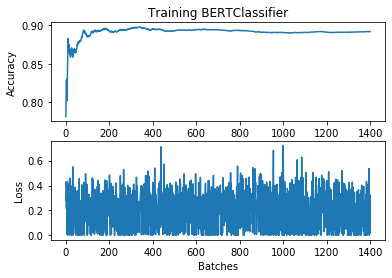

  0%|          | 0/600 [00:00<?, ?it/s]

Time for [4 - train model - 3]: 0:24:35.382324


100%|██████████| 600/600 [03:26<00:00,  2.91it/s]


Time for [prediction]: 0:03:26.023745
Accuracy in epoch 3: 0.8531114704501591
Confusion Matrix:
[[7644 1189]
 [1627 8711]]

Accuracy:  0.85 

Report for [BERTClassifier]:
              precision    recall  f1-score   support

           0       0.82      0.87      0.84      8833
           1       0.88      0.84      0.86     10338

    accuracy                           0.85     19171
   macro avg       0.85      0.85      0.85     19171
weighted avg       0.85      0.85      0.85     19171

Time for [6 - evaluate - 3]: 0:03:26.195614


100%|██████████| 44732/44732 [03:53<00:00, 191.87it/s]


Time for [setup training]: 0:03:53.162759
loaded checkpoint for epoch 0
loaded checkpoint for epoch 1
loaded checkpoint for epoch 2
loaded checkpoint for epoch 3
[Epoch 4 Batch 10/1401] loss=0.1999, lr=0.0000050, acc=0.900 - time 0:00:08.499479
[Epoch 4 Batch 20/1401] loss=0.2032, lr=0.0000050, acc=0.903 - time 0:00:09.043274
[Epoch 4 Batch 30/1401] loss=0.1673, lr=0.0000050, acc=0.909 - time 0:00:09.206156
[Epoch 4 Batch 40/1401] loss=0.2376, lr=0.0000050, acc=0.902 - time 0:00:09.747659
[Epoch 4 Batch 50/1401] loss=0.2558, lr=0.0000050, acc=0.897 - time 0:00:08.894597
[Epoch 4 Batch 60/1401] loss=0.1403, lr=0.0000050, acc=0.902 - time 0:00:08.579044
[Epoch 4 Batch 70/1401] loss=0.1478, lr=0.0000050, acc=0.905 - time 0:00:08.822484
[Epoch 4 Batch 80/1401] loss=0.1774, lr=0.0000050, acc=0.907 - time 0:00:08.244965
[Epoch 4 Batch 90/1401] loss=0.1907, lr=0.0000050, acc=0.909 - time 0:00:08.370028
[Epoch 4 Batch 100/1401] loss=0.1959, lr=0.0000050, acc=0.909 - time 0:00:09.237151
[Epoch 

[Epoch 4 Batch 970/1401] loss=0.2782, lr=0.0000050, acc=0.913 - time 0:00:09.324091
[Epoch 4 Batch 980/1401] loss=0.1410, lr=0.0000050, acc=0.913 - time 0:00:08.665544
[Epoch 4 Batch 990/1401] loss=0.1470, lr=0.0000050, acc=0.913 - time 0:00:08.708995
[Epoch 4 Batch 1000/1401] loss=0.1299, lr=0.0000050, acc=0.914 - time 0:00:08.253062
[Epoch 4 Batch 1010/1401] loss=0.2357, lr=0.0000050, acc=0.913 - time 0:00:09.042043
[Epoch 4 Batch 1020/1401] loss=0.1568, lr=0.0000050, acc=0.913 - time 0:00:08.531306
[Epoch 4 Batch 1030/1401] loss=0.2139, lr=0.0000050, acc=0.913 - time 0:00:09.233333
[Epoch 4 Batch 1040/1401] loss=0.1716, lr=0.0000050, acc=0.913 - time 0:00:07.815944
[Epoch 4 Batch 1050/1401] loss=0.1832, lr=0.0000050, acc=0.913 - time 0:00:08.179736
[Epoch 4 Batch 1060/1401] loss=0.0965, lr=0.0000050, acc=0.913 - time 0:00:08.553700
[Epoch 4 Batch 1070/1401] loss=0.1726, lr=0.0000050, acc=0.913 - time 0:00:07.734824
[Epoch 4 Batch 1080/1401] loss=0.1850, lr=0.0000050, acc=0.913 - tim

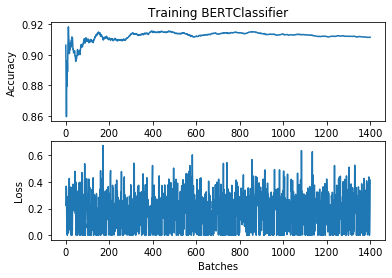

  0%|          | 0/600 [00:00<?, ?it/s]

Time for [4 - train model - 4]: 0:24:44.249447


100%|██████████| 600/600 [03:26<00:00,  2.91it/s]


Time for [prediction]: 0:03:26.281100
Accuracy in epoch 4: 0.8553022794846382
Confusion Matrix:
[[7546 1287]
 [1487 8851]]

Accuracy:  0.86 

Report for [BERTClassifier]:
              precision    recall  f1-score   support

           0       0.84      0.85      0.84      8833
           1       0.87      0.86      0.86     10338

    accuracy                           0.86     19171
   macro avg       0.85      0.86      0.85     19171
weighted avg       0.86      0.86      0.86     19171

Time for [6 - evaluate - 4]: 0:03:26.511770


In [26]:
for epoch_id in range(5):
    with Timer("4 - train model - {}".format(epoch_id)):
        stats = train(model, data_train, ctx, metric, loss_function, batch_size=32, lr=5e-6, num_epochs=epoch_id + 1)
        plot_train_stats(stats)

    with Timer("6 - evaluate - {}".format(epoch_id)):
        all_predictions, cum_loss = predict(model, data_dev, ctx, metric, loss_function)
        print("Accuracy in epoch {}:".format(epoch_id), metric.get()[1])
        y_true, y_pred = predict_out_to_ys(all_predictions, all_labels)
        report_training_results(y_true, y_pred, name="BERTClassifier", heatmap=False)

    model.save_parameters("data/bert.model.params")

### Cross topic - Training and evaluating model 

In [27]:
# 1. Getting train and dev data
with Timer("1 - test/train split"):
    X_train, X_dev, y_train, y_dev = get_train_test_sets(cross_traindev_df)

Time for [1 - test/train split]: 0:00:00.020626


In [28]:
# 2. setup
with Timer("2 - setup BERT model"):
    model, vocabulary, ctx, transform, loss_function, metric, all_labels = setup_bert()

BERTModel(
  (encoder): BERTEncoder(
    (dropout_layer): Dropout(p = 0.1, axes=())
    (layer_norm): BERTLayerNorm(eps=1e-12, axis=-1, center=True, scale=True, in_channels=768)
    (transformer_cells): HybridSequential(
      (0): BERTEncoderCell(
        (dropout_layer): Dropout(p = 0.1, axes=())
        (attention_cell): MultiHeadAttentionCell(
          (_base_cell): DotProductAttentionCell(
            (_dropout_layer): Dropout(p = 0.1, axes=())
          )
          (proj_query): Dense(768 -> 768, linear)
          (proj_key): Dense(768 -> 768, linear)
          (proj_value): Dense(768 -> 768, linear)
        )
        (proj): Dense(768 -> 768, linear)
        (ffn): BERTPositionwiseFFN(
          (ffn_1): Dense(768 -> 3072, linear)
          (activation): GELU()
          (ffn_2): Dense(3072 -> 768, linear)
          (dropout_layer): Dropout(p = 0.1, axes=())
          (layer_norm): BERTLayerNorm(eps=1e-12, axis=-1, center=True, scale=True, in_channels=768)
        )
        (la

In [29]:
with Timer("3 - prepare training data"):
    data_train_raw, data_train = transform_dataset(X_train, y_train, transform)
    print_infos(vocabulary, data_train_raw, data_train)

doctors that perform abortions are often emotionally damaged
unborn life should never depend on whether it is "wanted"
1
vocabulary used for tokenization = 
Vocab(size=30522, unk="[UNK]", reserved="['[PAD]', '[CLS]', '[SEP]', '[MASK]']")
[PAD] token id = 1
[CLS] token id = 2
[SEP] token id = 3
token ids = 
[    2  7435  2008  4685 11324  2015  2024  2411 14868  5591     3  4895
 10280  2166  2323  2196 12530  2006  3251  2009  2003  1000  2359  1000
     3     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     

In [ ]:
with Timer("4 - train model"):
    # train(model, data_train, ctx, metric, loss_function, batch_size=32, lr=5e-6, num_epochs=3)
    stats = train(model, data_train, ctx, metric, loss_function, batch_size=32, lr=5e-6, num_epochs=2)
    # model.save_parameters("data/same-side-classification/cross-topic/bert.model.params")
    model.save_parameters("data/bert.model.params")

    plot_train_stats(stats)

In [ ]:
# bert_dataloader = mx.gluon.data.DataLoader(data_train, batch_size=32)
# metric.reset()
# batch_id, (token_ids, valid_length, segment_ids,
#            label) = next(enumerate(tqdm(bert_dataloader)))
# # load data to GPU
# token_ids = token_ids.as_in_context(ctx)
# valid_length = valid_length.as_in_context(ctx)
# segment_ids = segment_ids.as_in_context(ctx)
# label = label.as_in_context(ctx)
# 
# # forward computation
# out = model(token_ids, segment_ids, valid_length.astype('float32'))
# label = label.astype('float32')
# ls = loss_function(out, label).mean()
# metric.update([label], [out])
# metric.get()
# # out = out.sigmoid().round().astype('int32')
# # label = label.astype('int32')
# pd.DataFrame.from_dict(
#     data={
#         "label": label.asnumpy().flatten(),
#         "out": out.asnumpy().flatten(),
#         "out.sigmoid": out.sigmoid().asnumpy().flatten(),
#         "out.sigmoid.round": out.sigmoid().round().asnumpy().flatten()
#     })

In [30]:
with Timer("5 - prepare eval data"):
    data_dev_raw, data_dev = transform_dataset(X_dev, y_dev, transform)
    print_infos(vocabulary, data_dev_raw, data_dev)

alcoholism and drug-use are common after abortions.
uncertainty over whether fetuses are "life" should halt abortions.
1
vocabulary used for tokenization = 
Vocab(size=30522, unk="[UNK]", reserved="['[PAD]', '[CLS]', '[SEP]', '[MASK]']")
[PAD] token id = 1
[CLS] token id = 2
[SEP] token id = 3
token ids = 
[    2 25519  1998  4319  1011  2224  2024  2691  2044 11324  2015  1012
     3 12503  2058  3251 10768  5809  2229  2024  1000  2166  1000  2323
  9190 11324  2015  1012     3     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     

In [32]:
with Timer("6 - evaluate"):
    # model.load_parameters("data/same-side-classification/cross-topic/bert.model.params", ctx=ctx)
    # model.load_parameters("data/bert.model.params", ctx=ctx)
    all_predictions, cum_loss = predict(model, data_dev, ctx, metric, loss_function)
    print("Accuracy:", metric.get()[1])

    y_true, y_pred = predict_out_to_ys(all_predictions, all_labels)
    report_training_results(y_true, y_pred, name="BERTClassifier", heatmap=False)

100%|██████████| 573/573 [03:22<00:00,  2.83it/s]


Time for [prediction]: 0:03:22.191523
Accuracy: 0.48402948402948404
Confusion Matrix:
[[8691  245]
 [9205  174]]

Accuracy:  0.48 

Report for [BERTClassifier]:
              precision    recall  f1-score   support

           0       0.49      0.97      0.65      8936
           1       0.42      0.02      0.04      9379

    accuracy                           0.48     18315
   macro avg       0.45      0.50      0.34     18315
weighted avg       0.45      0.48      0.33     18315

Time for [6 - evaluate]: 0:03:22.354048


In [ ]:
for epoch_id in range(5):
    with Timer("4 - train model - {}".format(epoch_id)):
        stats = train(model, data_train, ctx, metric, loss_function, batch_size=32, lr=5e-6, num_epochs=epoch_id + 1)
        plot_train_stats(stats)

    with Timer("6 - evaluate - {}".format(epoch_id)):
        all_predictions, cum_loss = predict(model, data_dev, ctx, metric, loss_function)
        print("Accuracy in epoch {}:".format(epoch_id), metric.get()[1])
        y_true, y_pred = predict_out_to_ys(all_predictions, all_labels)
        report_training_results(y_true, y_pred, name="BERTClassifier", heatmap=False)

    model.save_parameters("data/bert.model.params")